## Goodreads Books Reviews prediction

Hello,

In this notebook, I aim to provide predictions for the Goodreads Book Reviews competition. The notebook includes several steps such as exploratory data analysis (EDA), text cleaning, modeling with a Neural Network, and model analysis. Additionally, I have included some comments here and there or in the code.

Feel free to comment, criticize  or upvote this notebook.

### Getting the training data

In [1]:
# Import pandas
import pandas as pd

# Import training data
df_train = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')

# Print few random entries
df_train.sample(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
863493,8c3513d1f5162adb9fbe86eaad9e104e,16143347,899326d243bf425f75873dc15e512c85,5,I resisted reading any additional reviews of t...,Mon Jun 29 10:49:28 -0700 2015,Wed Jan 06 13:40:46 -0800 2016,Thu Sep 24 00:00:00 -0700 2015,Wed Sep 23 00:00:00 -0700 2015,2,0
302117,69d9a3089b9c04b6fbb81c71722bf7f9,2412562,19c99a722a26e326d4b1cfd00340a798,4,I really enjoyed this book. I like the style o...,Tue Jul 22 14:08:56 -0700 2008,Thu Jan 15 08:17:36 -0800 2009,Fri Jan 09 00:00:00 -0800 2009,NaN,0,0
318155,af60ce5704a5593ff41df605dd0001ce,11099135,1e7216c3eea114e5943311d611654f37,4,Four and half stars! This was the best book in...,Tue Jun 23 09:42:55 -0700 2015,Tue Jun 30 09:39:29 -0700 2015,Tue Jun 30 09:39:29 -0700 2015,Tue Jun 23 00:00:00 -0700 2015,0,0
79500,95a1585c5a7df785f85363d22f63da03,4374400,ceb36b7085dc7defa34d3c3f308e66ac,4,I always considered myself to be a pretty toug...,Sat Feb 02 07:04:52 -0800 2013,Wed Feb 06 21:16:20 -0800 2013,Wed Feb 06 00:00:00 -0800 2013,Sat Feb 02 00:00:00 -0800 2013,0,0
476220,33162c8e64b16bcbddc9808f3c716342,10964,e2fdfce30f5e2f7faa03c33ec68439a6,3,"I made it! Silly, silly book. Take that, 2011!",Fri Oct 01 03:09:15 -0700 2010,Sat Dec 31 23:36:32 -0800 2011,Sat Dec 31 00:00:00 -0800 2011,Sat Dec 31 00:00:00 -0800 2011,1,16


### EDA

In [2]:
# Checking the number of rows and columns
print("The DataFrame has " + str(df_train.shape[0]) + " samples and " + str(df_train.shape[1]) + " columns")

The DataFrame has 900000 samples and 11 columns


In [3]:
# Check duplicates
print("Duplicate entries in the dataset: " + str(df_train.duplicated().sum()))

Duplicate entries in the dataset: 0


In [4]:
# Check null values and data type of each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


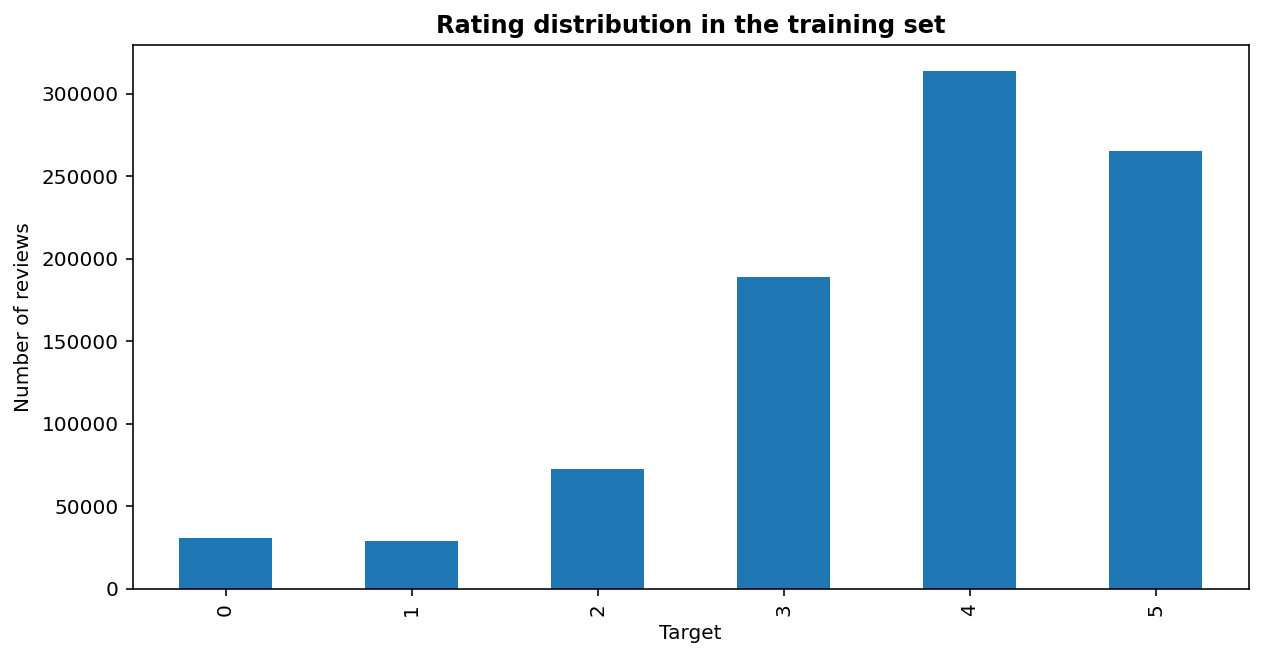

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# Check target balance
df_train['rating'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Rating distribution in the training set', fontweight="bold")
plt.xlabel('Target')
plt.ylabel('Number of reviews')
plt.show()

This bar plot is pretty self-explanatory, with most of the ratings having 4 or 5 stars.

Now, I will focus on the text data, hence drop the columns that I won't need anymore in this project.

In [6]:
# Drop few columns
df_train = df_train.drop(columns=['user_id','book_id','date_added','date_updated',
                                  'read_at','started_at','n_votes','n_comments'])

At this point we can write a function to clean the raw text and make it more appropriate for the modeling part.

In [7]:
import re
from nltk.corpus import stopwords

# Create a stopwords set adding some personal 'words'
stopwords_english = set(stopwords.words('english'))
my_stopwords = set(["http", "'s", "n't", "'m", "'re", "'ve"])
stopwords_english.update(my_stopwords)

def preprocess_review(text):
    # Convert to lower case
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Split text into tokens
    tokens = text.split()

    # Filter tokens
    clean_tokens = [tok for tok in tokens if tok not in stopwords_english and len(tok) > 1]

    # Join tokens into a string
    clean_text = ' '.join(clean_tokens)

    return clean_text

There are multiple ways to clean text, including stemming and lemmatization. Although these techniques can enhance the outcome, they also slow down the function considerably, especially for larger datasets like this one. For instance, my previous function using these techniques took more than an hour to train the dataset, whereas the new solution takes a little over a minute. Therefore, I opted for a faster function even though it may result in slightly less accuracy. 

Let's check it out:

In [8]:
# Get one review as sample
sample = df_train['review_text'][5]

print('ORIGINAL REVIEW:   ' + sample + '\n')
print('---------------------------------------------------------------------------- \n')
print('WITH PROCESSING:    ' + preprocess_review(sample))

ORIGINAL REVIEW:   A beautiful story. It is rare to encounter a book that does such a good job painting the scenes in your mind - you really felt like you were there and got to know the characters and the people they came across. I generally love WWII books and movies, but wasn't sure if I'd like one featuring a blind girl and a young Nazi radio operator - but he brings a lot of life to them. 
 That said, the novel drifts around a lot, and the plotline jumping forward and backward in time drove me nuts. 
 I thought a lot about if there is a theme to the book. One was the diamond and if it was really cursed (based on the Hope Diamond perhaps?). Another is that 20K Leagues is an awesome book. But I think the book was a lot about fear and the unknown, and how people deal with it. Marie-Laure was blind and couldn't tell what was happening around her - yet she was the bravest one. Werner was afraid of ending up as a miner, which drove him to join the army, and learn about radios. And Uncle 

Not bad, should work well enough. Let's apply the function to all the corpus:

In [9]:
%%time

# Preprocess training data adding new column
df_train["clean_text"] = df_train["review_text"].apply(preprocess_review)

CPU times: user 1min 23s, sys: 931 ms, total: 1min 24s
Wall time: 1min 24s


Let's perform some additional EDA with the cleaned text

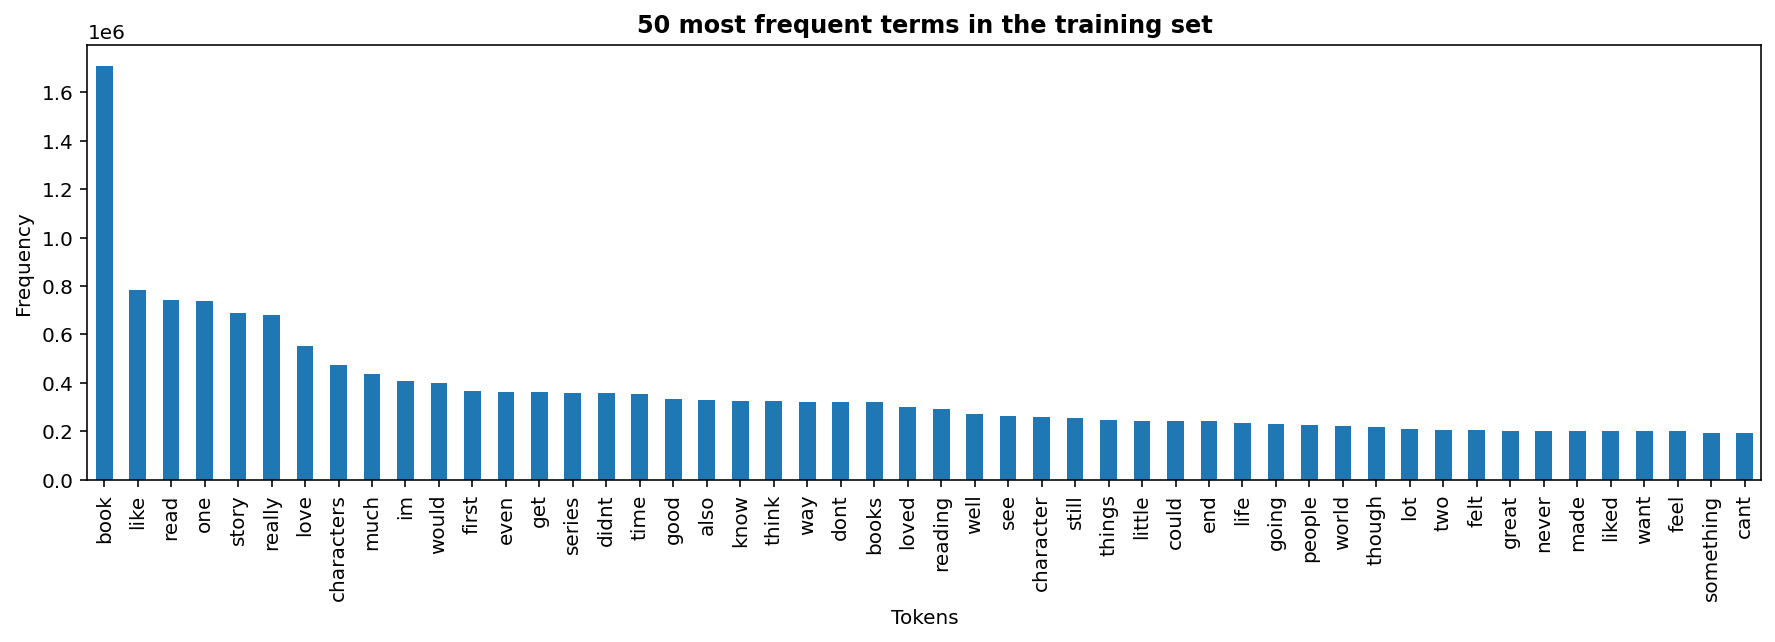

In [10]:
# Get 50 most frequent words in the training set
frequent_words = pd.Series(' '.join(df_train.clean_text).split()).value_counts()[:50]
frequent_words.plot.bar(figsize=(15,4))
plt.title('50 most frequent terms in the training set', fontweight="bold")
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.show()

In [11]:
# I found that the variable 'frequent_words' takes up about 6 Gb of RAM! Better clean it up!
import gc

del frequent_words

gc.collect()

9272

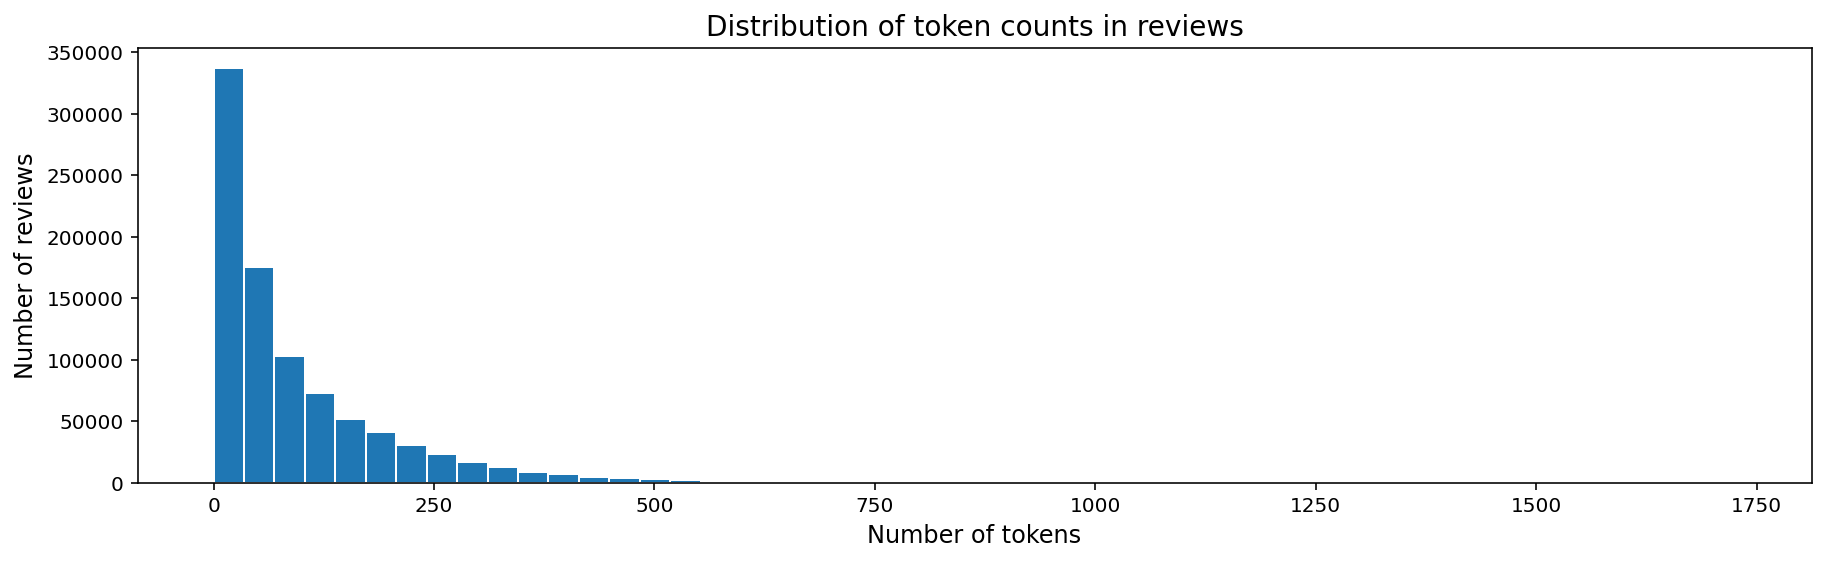

In [12]:
# Plot the number of tokens in cleaned reviews
plt.figure(figsize=(15,4))
plt.hist(df_train['clean_text'].apply(lambda x:len(x.split())), bins=50, edgecolor='white')
plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of reviews',fontsize=12)
plt.title('Distribution of token counts in reviews', fontsize=14)
plt.show()

In [13]:
# Filter rows with less than 250 tokens
less_than_250 = df_train['clean_text'].apply(lambda x: len(x.split())) < 250  # Check by getting True and False values

# Print percentage
print(f"{(sum(less_than_250) / len(df_train) * 100):.2f}% of rows have less than 250 tokens.")

90.80% of rows have less than 250 tokens.


What does this mean? As visible in the token distribution graph, most reviews are not very long, although a few reach a length greater than 1500 tokens.

Let's get our final processed training set:

In [14]:
# Remove original text column
df_train = df_train.drop(columns=['review_text'])

# Get few entries to check operation
df_train.head()

,review_id,rating,clean_text
0,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,special book started slow first third middle t...
1,a5d2c3628987712d0e05c4f90798eb67,3,recommended katz avail free december httpwwwau...
2,2ede853b14dc4583f96cf5d120af636f,3,fun fast paced science fiction thriller read n...
3,ced5675e55cd9d38a524743f5c40996e,0,recommended reading understand going middle am...
4,332732725863131279a8e345b63ac33e,4,really enjoyed book lot recommend drag little ...


### Test Set

Importing and processing the text data as did in the training set

In [15]:
# Import training data
df_test = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv')

# Print a random row
df_test.sample()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
25761,b986581bdf2ce6e52cf9c9ad63c63422,22557272,ea241fd302f869072dd6fb81374785bb,"I give this 4/5 oh-em-gees and one ""Thought so...",Mon Aug 22 22:05:38 -0700 2016,Tue Aug 23 14:44:52 -0700 2016,Tue Aug 23 14:44:52 -0700 2016,Sat Aug 20 00:00:00 -0700 2016,0,0


In [16]:
%%time

# Remove unceccessary columns
df_test = df_test.drop(columns=['user_id','book_id','date_added','date_updated',
                                  'read_at','started_at','n_votes','n_comments'])

# Preprocess training data adding new column
df_test["clean_text"] = df_test["review_text"].apply(preprocess_review)

# Remove original text column
df_test = df_test.drop(columns=['review_text'])

# Get few entries to check cleaning operation
df_test.head()

CPU times: user 44.5 s, sys: 263 ms, total: 44.7 s
Wall time: 44.7 s


,review_id,clean_text
0,5c4df7e70e9b438c761f07a4620ccb7c,spoiler alert definitely one favorites among f...
1,8eaeaf13213eeb16ad879a2a2591bbe5,spoiler alert drink im huge fan coffee dont bu...
2,dce649b733c153ba5363a0413cac988f,roar one favorite characters never sky im happ...
3,8a46df0bb997269d6834f9437a4b0a77,spoiler alert feel like travelling europe dont...
4,d11d3091e22f1cf3cb865598de197599,stars read enjoyed first two novels series say...


### Split the data

In [17]:
# Create X, y arrays
from sklearn.model_selection import train_test_split

# Training data
X_train = df_train["clean_text"].values
y_train = df_train["rating"].values

# Split into train/test sets
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Test data
X_te = df_test["clean_text"].values

print("Training data:", X_tr.shape, y_tr.shape)
print("Validation data:", X_va.shape, y_va.shape)
print("Test data:", X_te.shape)

Training data: (720000,) (720000,)
Validation data: (180000,) (180000,)
Test data: (478033,)


### Model Part

Given the dataset's size and my preference for using a Neural Network model, it's certainly worthwhile to employ an accelerator. Below are the default setup settings for enabling the TPU (Tensor Processing Unit).

In [18]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

In [19]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


Now, this code uses the Keras module from TensorFlow to preprocess text data. Specifically, it uses the 'Tokenizer' function to convert the text into a sequence of integers, and the 'pad_sequences' function to ensure that each sequence has the same length.

In [20]:
%%time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_tr)

max_seq_length = 250

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_tr_seq = pad_sequences(X_tr_seq, maxlen=max_seq_length)

X_va_seq = tokenizer.texts_to_sequences(X_va)
X_va_seq = pad_sequences(X_va_seq, maxlen=max_seq_length)

X_te_seq = tokenizer.texts_to_sequences(X_te)
X_te_seq = pad_sequences(X_te_seq, maxlen=max_seq_length)

CPU times: user 3min 17s, sys: 1.99 s, total: 3min 19s
Wall time: 3min 19s


Let's build the model. There are various approaches available, but I decided to experiment with a combination of several different layers, including a convolutional layer and a bidirectional LTSM layers. Probably these ones may be responsible for slowing down the training time more than the other layers. Anyway, let's evaluate it afterwards:

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim=20000, output_dim=128, input_length=250))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units=128)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(units=32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(units=6, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc']
                 )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 128)          2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 248, 64)           24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 124, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 124, 128)          66048     
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 128)          512       
_________________________________________________________________
dropout (Dropout)            (None, 124, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               2

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Creates 'EarlyStopping' callback
earlystopping_cb = EarlyStopping(patience=4, restore_best_weights=True)

In [23]:
%%time

history = model.fit(X_tr_seq,
                    y_tr,
                    validation_data=(X_va_seq, y_va),
                    callbacks=[earlystopping_cb],
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                   )

Epoch 1/15
11250/11250 [==============================] - 283s 24ms/step - loss: 1.5674 - acc: 0.3727 - val_loss: 1.1157 - val_acc: 0.5241
Epoch 2/15
11250/11250 [==============================] - 273s 24ms/step - loss: 1.1252 - acc: 0.5248 - val_loss: 1.0574 - val_acc: 0.5491
Epoch 3/15
11250/11250 [==============================] - 270s 24ms/step - loss: 1.0430 - acc: 0.5659 - val_loss: 1.0515 - val_acc: 0.5581
Epoch 4/15
11250/11250 [==============================] - 270s 24ms/step - loss: 0.9775 - acc: 0.6021 - val_loss: 1.0672 - val_acc: 0.5515
Epoch 5/15
11250/11250 [==============================] - 273s 24ms/step - loss: 0.9126 - acc: 0.6389 - val_loss: 1.1133 - val_acc: 0.5456
Epoch 6/15
11250/11250 [==============================] - 272s 24ms/step - loss: 0.8514 - acc: 0.6740 - val_loss: 1.1342 - val_acc: 0.5408
Epoch 7/15
11250/11250 [==============================] - 274s 24ms/step - loss: 0.7913 - acc: 0.7053 - val_loss: 1.1934 - val_acc: 0.5332
CPU times: user 9min 38s, s

Indeed, not as fast as others NN configuration out there. Moving on, it's always a good practice to evaluate the model by seeing the training/validation curves as done below:

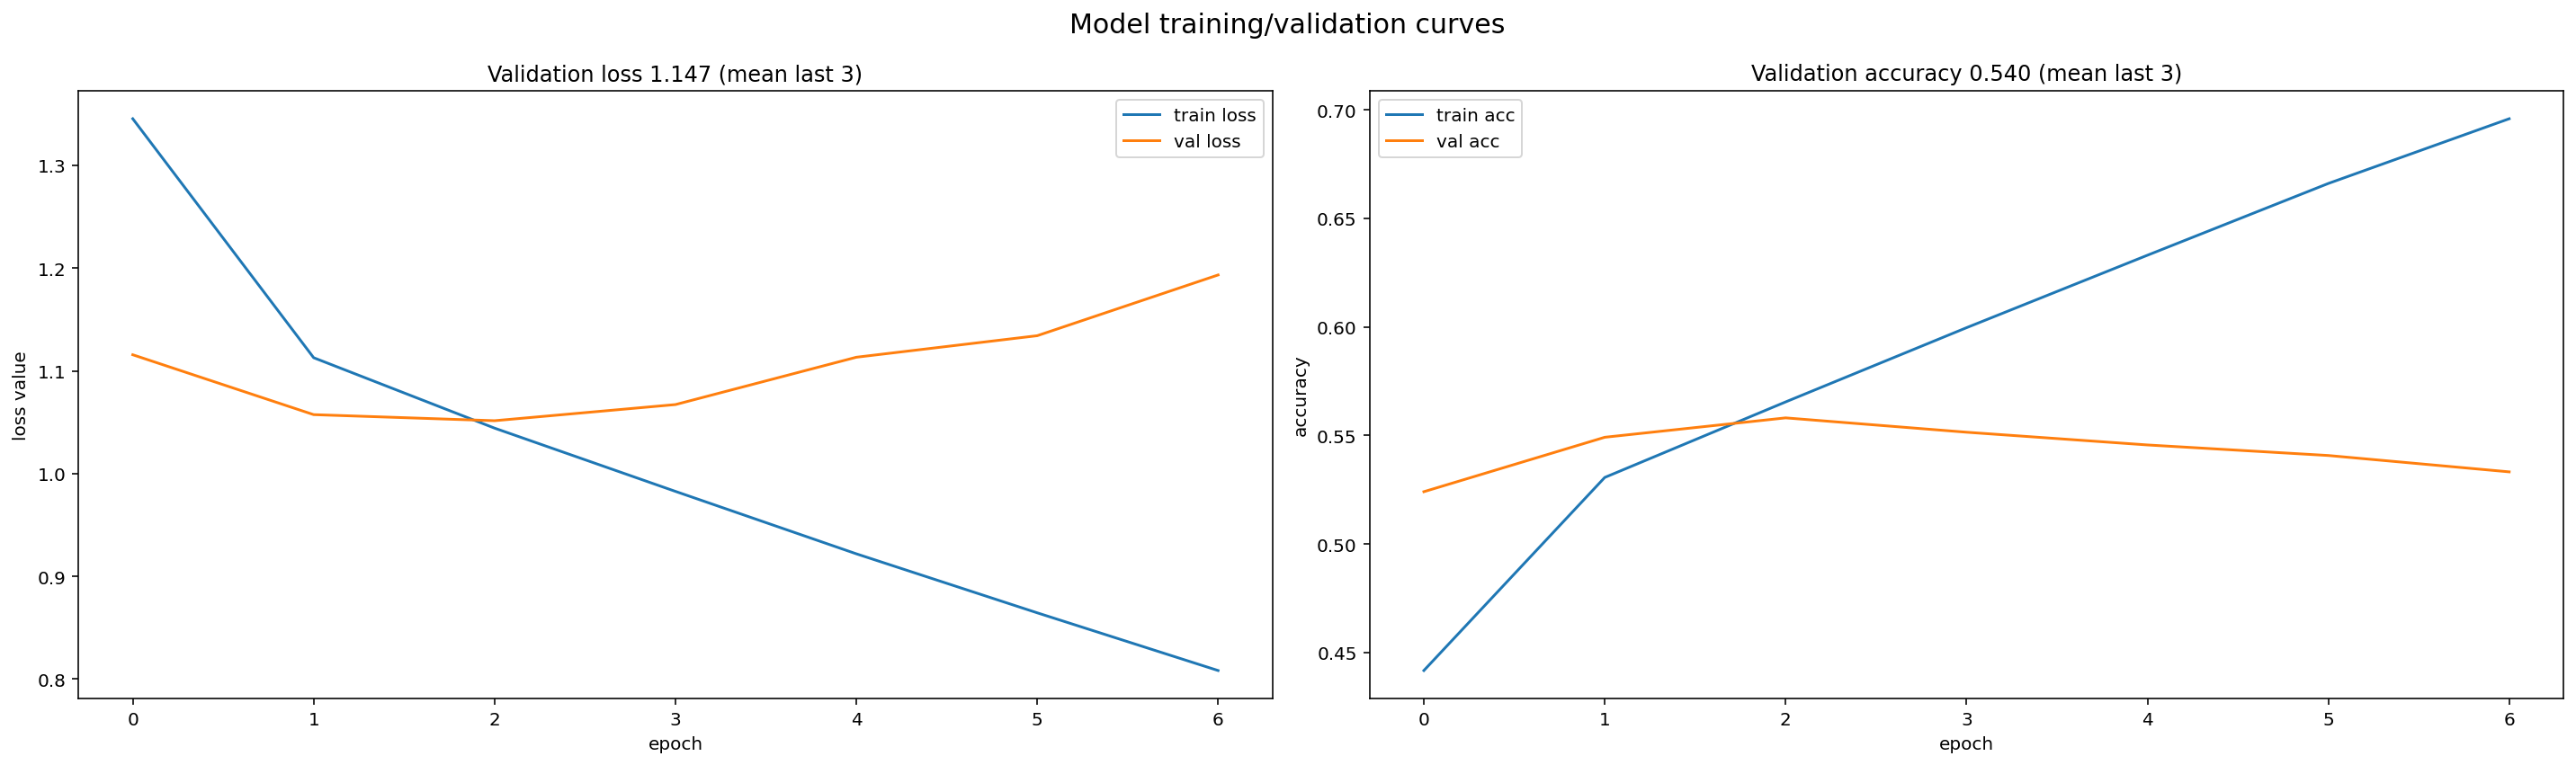

In [24]:
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Model training/validation curves', size=15)

# Plot loss values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.show()

Here we see that only after 2 epoch the curves begin to diverge, a sign of overfitting. We can get the results on the validation set and plot the confusion matrices to further see the performance of the model

In [25]:
test_loss, test_acc = model.evaluate(X_va_seq,y_va)

print('Validation loss:', test_loss)
print('Validation accuracy:', test_acc)

5625/5625 [==============================] - 82s 14ms/step - loss: 1.0513 - acc: 0.5581
Validation loss: 1.0513246059417725
Validation accuracy: 0.5581111311912537


In [26]:
# Compute validation set predictions
pred = [np.argmax(i) for i in model.predict(X_va_seq)]

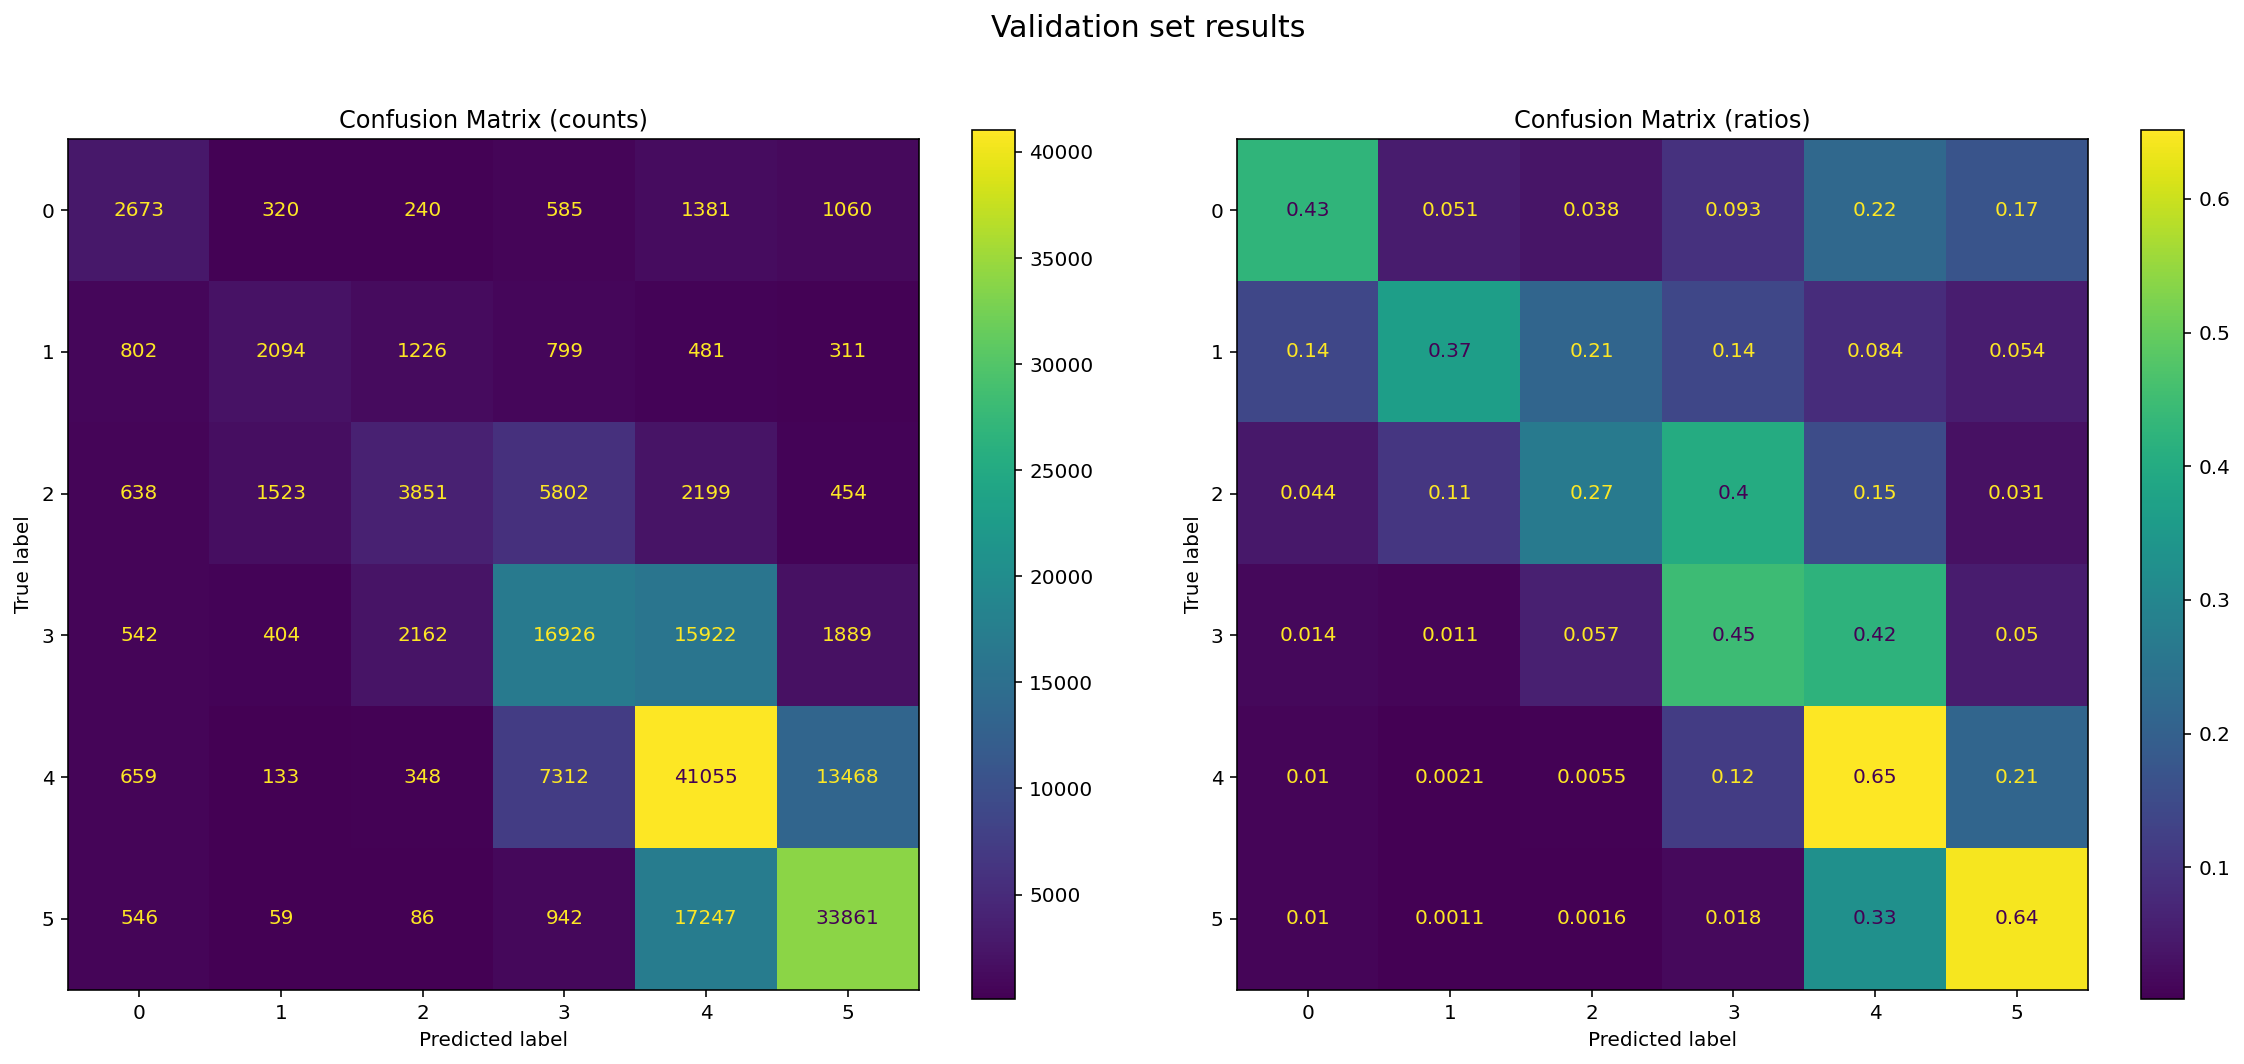

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for raw counts
cm_raw = confusion_matrix(y_va, pred)

# Compute confusion matrix for normalized ratios
cm_norm = confusion_matrix(y_va, pred, normalize='true')

# Create confusion matrix plots
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={"width_ratios": [10, 10], "wspace": 0.1}, subplot_kw={"aspect":"equal"})
plt.suptitle('Validation set results', size = 15)
disp_raw.plot(ax=axs[0])
axs[0].set_title('Confusion Matrix (counts)')
disp_norm.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix (ratios)')
plt.show()

Based on the confusion matrices in the validation set, we can see that the model performed better with 4 and 5-star ratings. This is not surprising given that these ratings had the largest number of samples available for the training.

Concerning the errors, overall the model tends to predict ratings that are close to each other, for instance often mistakenly predicting a rating of 2 for a rating of 3, or vice versa.

### Make predictions

In [28]:
# Compute test set predictions
predictions = [np.argmax(i) for i in model.predict(X_te_seq)]
    
# Create a new DataFrame to merge review ids and the model predictions
submission = pd.DataFrame({'review_id': df_test.review_id, 'rating': predictions})

# Check few random entries
submission.sample(10)

,review_id,rating
462338,e8f65cc95bb1eefb7e0eb9ece7b086cd,5
49135,723e1b2efd1cbd1e14b8b2878ad04855,5
298861,af4f19e8e4a0d2cb92f9dc14202cfeb3,4
102150,6c85bab2c9663d48631a843926727c75,3
273046,fc6b2e2f738f750b0528a59007dcf589,3
313326,a2a1a6a50b80b82c76cca46075b41ed6,3
236564,6698825c13fb84afc8291141d803ee55,5
168522,45a40a608324435199f87ba5ffaa0094,2
420022,f992629b735c8db2e32a0fb65ffc59a6,5
64388,646be3f5a4c48d66275f6bdfc02807a2,5


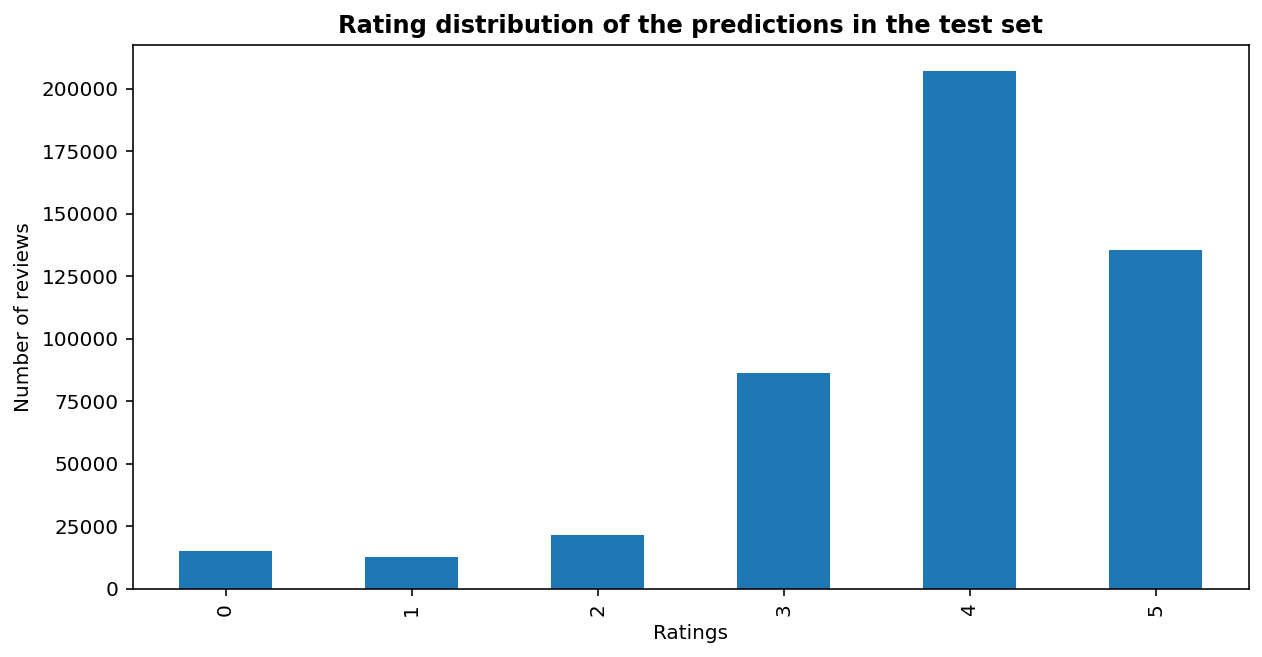

In [29]:
# Check target balance
submission['rating'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Rating distribution of the predictions in the test set', fontweight="bold")
plt.xlabel('Ratings')
plt.ylabel('Number of reviews')
plt.show()

The target distribution in the test set is similar to the one in training set. 

In [30]:
# Export predictions
submission.to_csv("submission.csv", index=None)

Final score of this notebook: ~0.55